In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn as nn
import numpy as np
import torchvision as tv
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pytorch_lightning as pl
import random
plt.rcParams['figure.figsize'] = [20, 10]
script_dir = os.path.dirname('__file__')
sys.path.append(os.path.join(script_dir, '..', 'src'))
from subset import Subset


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
seed = 45
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [12]:
# load dataset untransformed 
root = os.path.join("/", "space", "derma-data")
whole_dataset = datasets.ImageFolder(root, transforms.ToTensor())
train_data = Subset(whole_dataset, np.random.permutation(len(whole_dataset)-1))


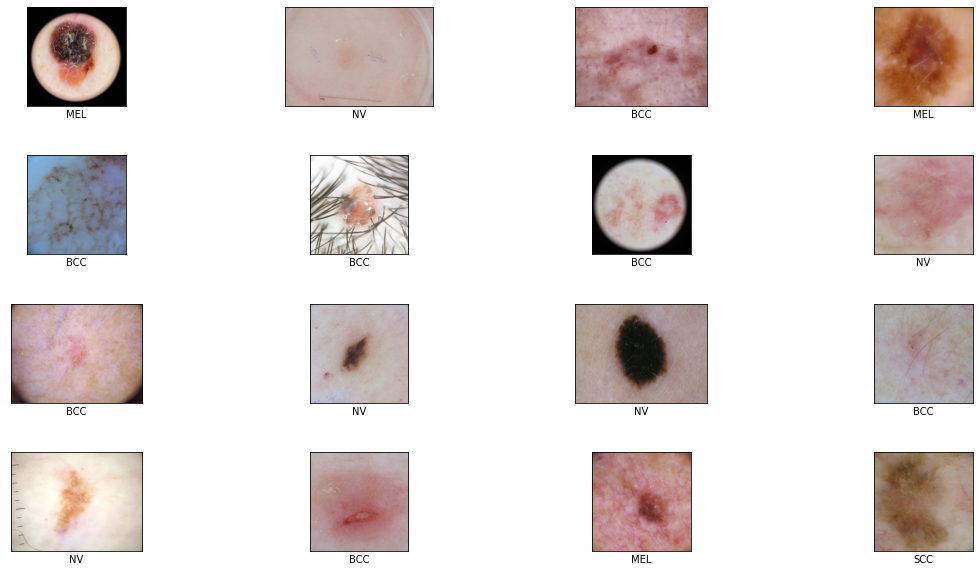

In [14]:
# Show 16 images:
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        ax[i, j].imshow(train_data[i * 4 + j][0].transpose(2,0).transpose(0,1).numpy())
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

In [15]:
# all basic transforms concluded by cropping to (224,224)
img_transforms = nn.Sequential(transforms.RandomRotation(degrees=(0, 180)),transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip(), transforms.Resize((224, 224)))

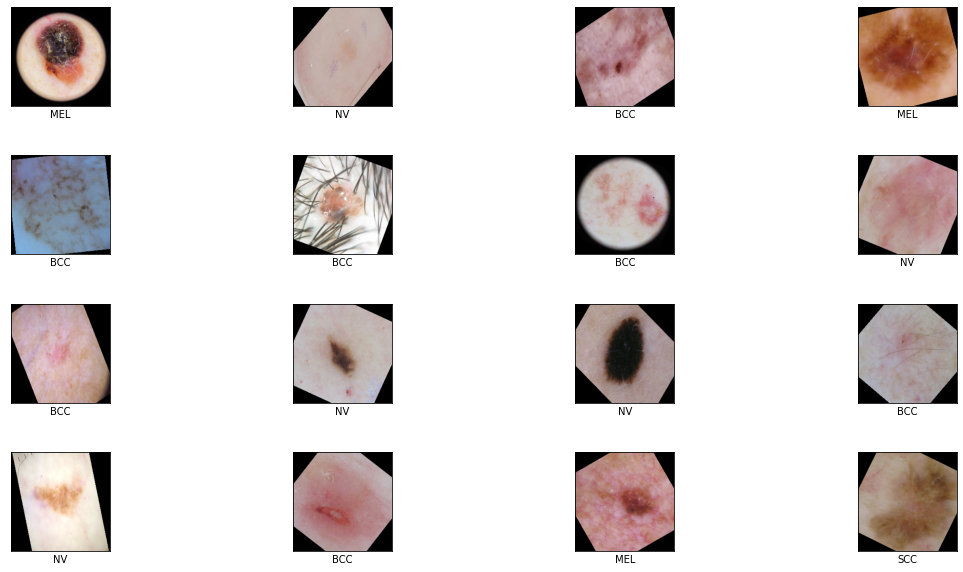

In [17]:
# Effect of using first rotations then cropping to size (224,224)
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = train_data[i * 4 + j][0].numpy()
        trf_img = img_transforms(torch.from_numpy(image_np))
        trf_img = trf_img.numpy()
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

In [18]:
# all basic transforms in original sequence
original_transforms = nn.Sequential(transforms.Resize((224, 224)),transforms.RandomRotation(degrees=(0, 180)),transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip())

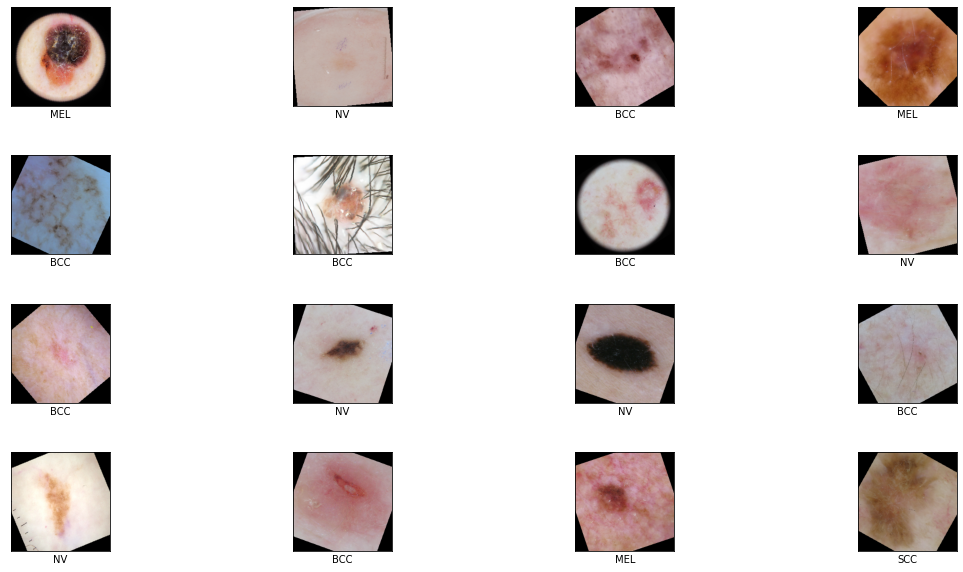

In [20]:
# Effect of using cropping to size (224,224) first then basic transformations
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = train_data[i * 4 + j][0].numpy()
        trf_img = original_transforms(torch.from_numpy(image_np))
        trf_img = trf_img.numpy()
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

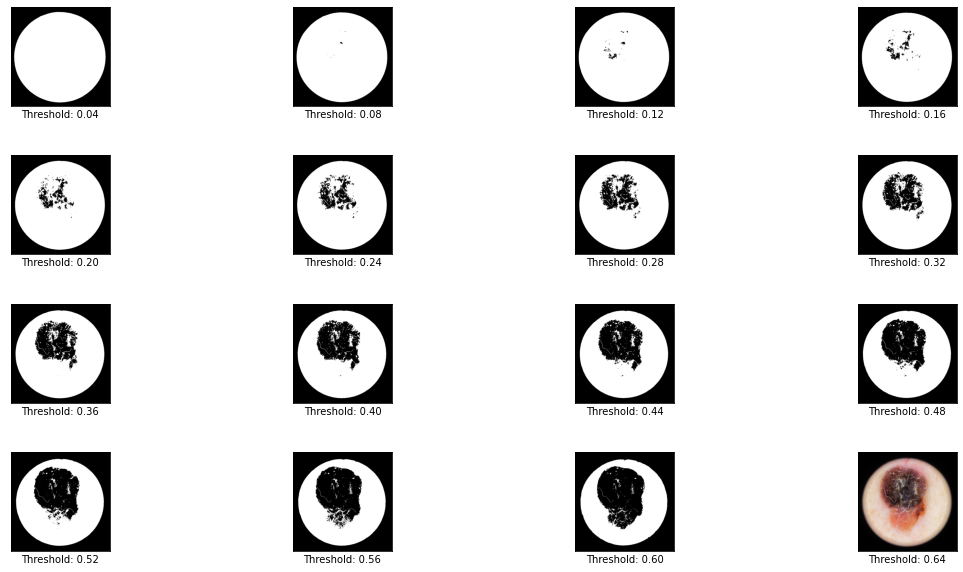

In [21]:

img = None
for k in range(0,100):
    # find first image with a black pixel
    if (train_data[k][0].min() < 0.005):
        img = k
        f, ax = plt.subplots(4, 4)
        f.subplots_adjust(hspace=0.5, wspace= 0.05)
        for i in range(0, 4):
            for j in range(0, 4):
                # convert to black-white image via threshold
                threshold = 0.04 * (i * 4 + j) + 0.04
                grey_img = (torch.sum(train_data[k][0], dim=0) / 3)
                ax[i, j].imshow((1.0 * (grey_img >= threshold)).numpy(), cmap="gray")
                ax[i,j].yaxis.set_visible(False)
                # ax[i,j].xaxis.set_visible(False)
                ax[i,j].set_xlabel(f"Threshold: {threshold:.2f}")
                ax[i,j].xaxis.set_ticklabels([])
                ax[i,j].xaxis.set_ticklabels([])
                ax[i,j].xaxis.set_ticks([])
        break   # Search for the first image with a black border

plt.imshow(train_data[k][0].transpose(0,2).transpose(0,1).numpy(), cmap="gray")

In [23]:
grey_img = (torch.sum(train_data[img][0], dim=0) / 3).numpy()

In [37]:
edge = 0.01
images_with_black_edges = []

In [39]:
# Filter out some images with black edges
for k in range(0,100):
        image = train_data[k][0]
        grey_img = (torch.sum(image, dim=0) / 3).numpy()
        has_black_edges = ((np.average(grey_img[0][:]) < edge) and (np.average(grey_img[-1][:]) < edge) and (np.average(grey_img[:][0]) < edge) and (np.average(grey_img[:][-1]) < edge))
        if(has_black_edges):
            images_with_black_edges.append(train_data[k])

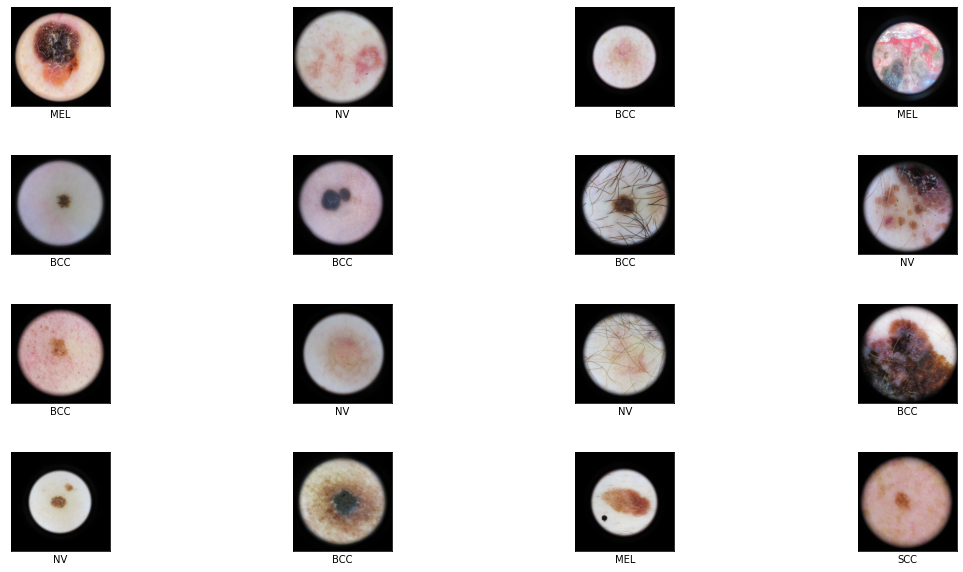

In [42]:
# Testing filtering the images with black edges all around
f, ax = plt.subplots(4, 4)
f.subplots_adjust(hspace=0.5, wspace= 0.05)
for i in range(0, 4):
    for j in range(0, 4):
        image_np = images_with_black_edges[ i* 4 + j][0]
        trf_img = image_np.numpy()
        trf_img = np.transpose(trf_img,(1,2,0))
        ax[i, j].imshow(trf_img)
        ax[i,j].yaxis.set_visible(False)
        # ax[i,j].xaxis.set_visible(False)
        ax[i,j].set_xlabel(train_data.idx_to_class[train_data[4*i + j][1]])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticklabels([])
        ax[i,j].xaxis.set_ticks([])

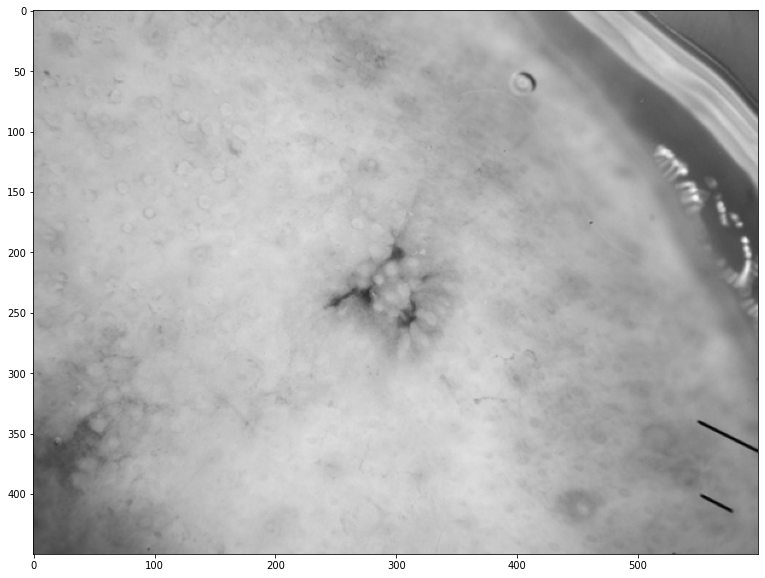

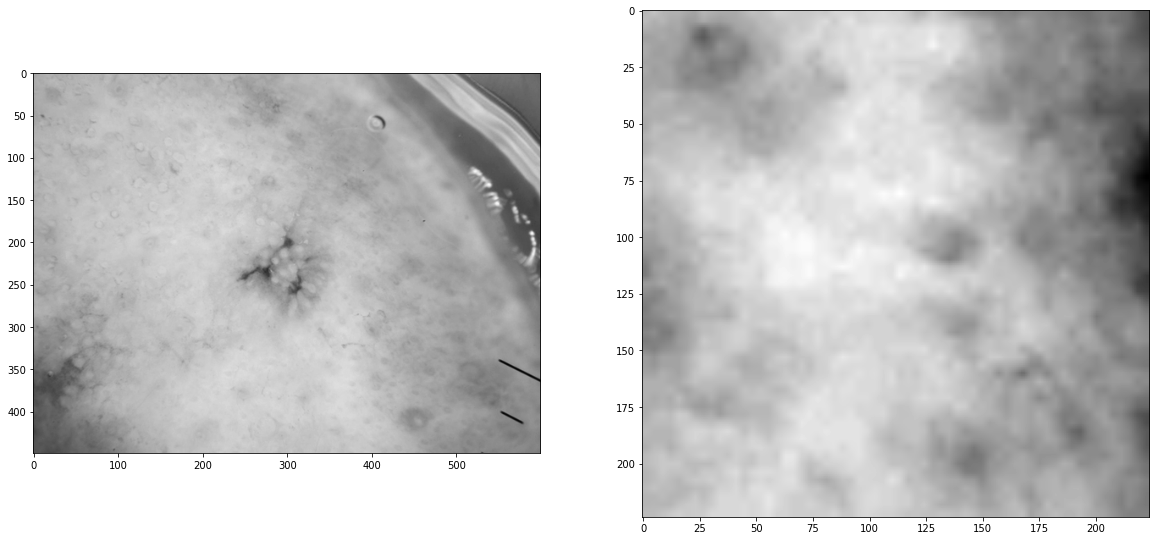

In [ ]:
blwh_img = (1.0 * (grey_img >= 0.12))
plt.imshow(grey_img, cmap='gray')
cov_m = np.cov(blwh_img)
eig_values, eig_vectors = np.linalg.eig(cov_m)
test = ((cov_m) > 0.001)
coor = np.unravel_index(np.argmax(test),test.shape)
box_idx = np.argwhere(test>0)
outer_points = np.argmax(box_idx, axis=0)
height= np.abs(box_idx[outer_points[0],0] - box_idx[outer_points[0],1])
width = np.abs(box_idx[outer_points[1],0] - box_idx[outer_points[1],1])
cropped_img = tv.transforms.functional.resized_crop(torch.from_numpy(grey_img[None,:]), top=box_idx[0,0], left=box_idx[0,1], 
                                                            height= height, 
                                                            width= width, size=224)
f, ax = plt.subplots(1, 2)
ax[0].imshow(grey_img, cmap='gray')
ax[1].imshow(cropped_img[0], cmap='gray')

In [44]:
def compute_weights(dataset, relatively_weighted):
    class_sample_count = np.unique(dataset.targets, return_counts=True)[1]
    weights = 1.0 / class_sample_count
    if(relatively_weighted):
        top_k_weights = np.sort(weights.numpy())[-3 :]
        average_weight = np.average(top_k_weights)
        weights = weights + average_weight
    weights_per_sample = np.array([weights[t] for t in dataset.targets])
    return torch.from_numpy(weights).float(), torch.from_numpy(weights_per_sample).float()

In [67]:
# Testing weighting the classes relatively to their imbalance
weights, _ = compute_weights(train_data.dataset, False)
top_k_weights = np.sort(weights.numpy())[-3 :]
average_weight = np.average(top_k_weights)
weights_expanded, _ = compute_weights(train_data.dataset, True) * 100
print((weights_expanded.numpy()))
print((weights.numpy()*100))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

[0.43964112 0.35439417 0.36241063 0.7427109  0.34641498 0.33206785
 0.48353654 0.7195578 ]
[0.11534025 0.03009329 0.03810975 0.41841003 0.02211411 0.00776699
 0.15923567 0.39525694]
